In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [ ]:
%load_ext autoreload
%autoreload 2
import cProfile
from datetime import datetime
import importlib
import numpy as np
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def execute_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    logger = make_logger(output_dir)

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path, device=conf.get("device"))
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    policy_class = class_from_package("policy", conf.get("policy_class"))
    policy = policy_class(**conf.get("policy_conf", {}))

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization
    generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf", {}))

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)

    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    # cProfile.run("generator.generate(root=root, **generation_conf)"")
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()
    
    return generator

def queue_yaml(*args: str):
    for yaml_path in args:
        generator = execute_yaml(yaml_path)
        generator = None

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting generation...


a


1- time: 0.00, reward: 0.0, node: C[C@H]1C(=O)N(Cc2nc3c(CC(C)C)nnn3s2)C[C@@H]1O
2- time: 0.79, reward: 0.3867421452982643, node: NC(=O)COc1ccc(S(=O)(=O)N2CCC[C@H](C)C2)cc1
3- time: 0.79, reward: 0.0, node: Nc1cccc(C[NH+]2C[C@H](C(=O)[O-])C2)c1C(=O)[O-]
4- time: 0.79, reward: 0.4195816848300604, node: N#Cc1ccc(NC(=O)c2ccc(OC)cc2)o1
5- time: 1.06, reward: 0.42516484345240163, node: FC1(F)CCC[C@H]1NC(=O)N1CCCC[C@H]1C
6- time: 1.32, reward: 0.0, node: [NH3+]C(=O)Cc1cccc(OCCNC(=O)c2ccc(Cl)c(F)c2)c1
7- time: 1.83, reward: 0.3904278004159191, node: ClC(F)(F)CCNc1ccncc1
8- time: 1.83, reward: 0.31847456573533206, node: Clc1ccccc1[C@H]1CCN(Cc2ccccc2)C1
9- time: 2.01, reward: 0.0, node: S[C@H]1CCC[C@@H]1NC(=O)CN1C[C@@H](C)CS(=O)(=O)C1
10- time: 2.01, reward: 0.0, node: S=C(Nc1nccc(CNc2ccccc2)c1)N1CCCCC1
11- time: 2.29, reward: 0.21706182773405455, node: Fc1ccc(-n2cnnc2C(F)F)cc1Br
12- time: 2.53, reward: 0.4228224059334656, node: Cl[C@H]1CCC[C@@H]1NC(=O)NCC1CCCCCC1
13- time: 2.53, reward: 0.0, no

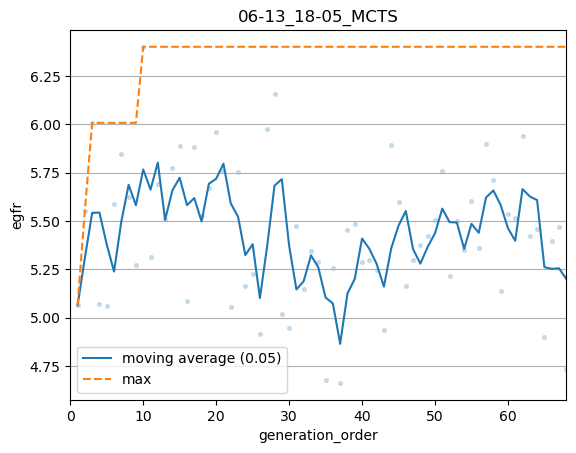

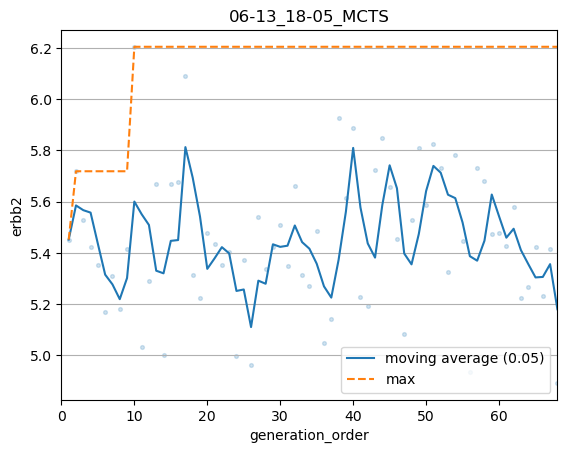

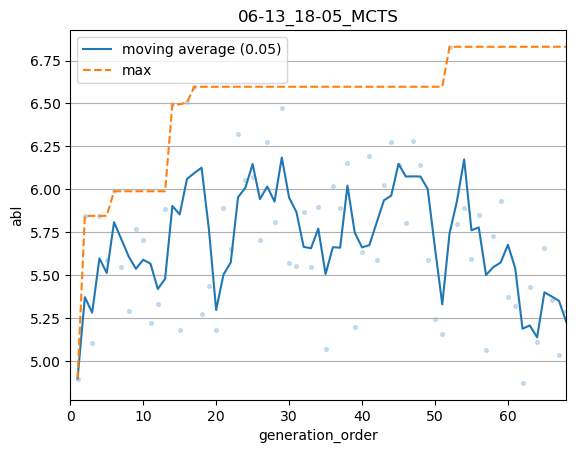

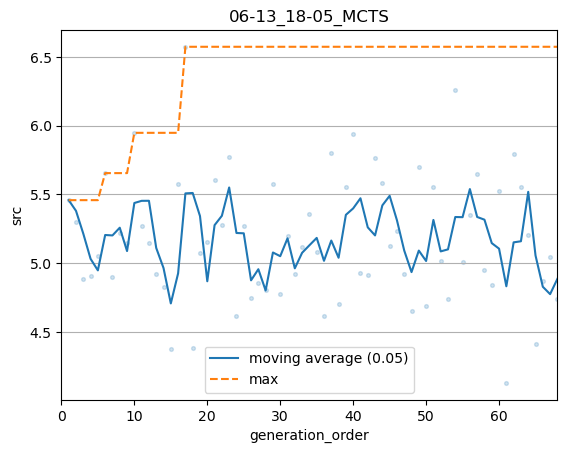

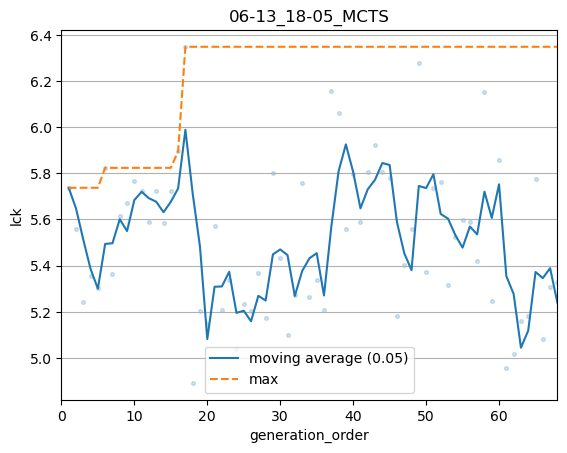

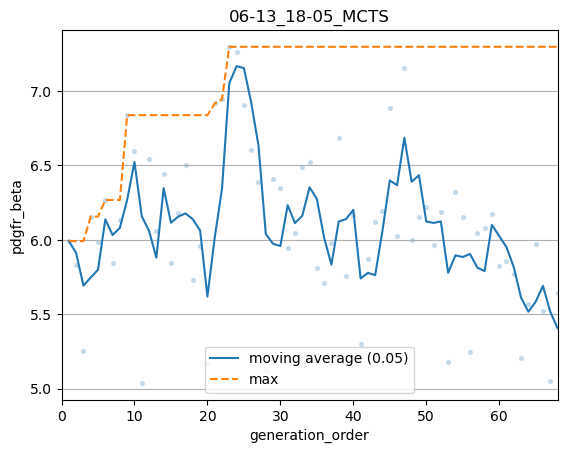

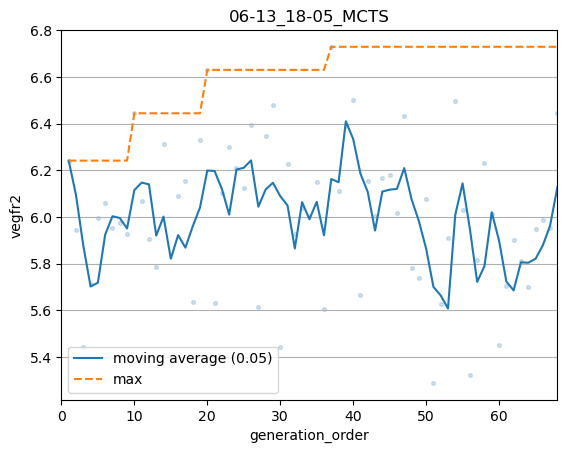

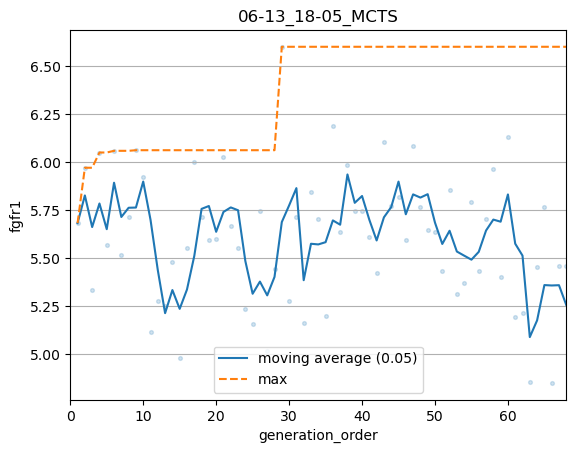

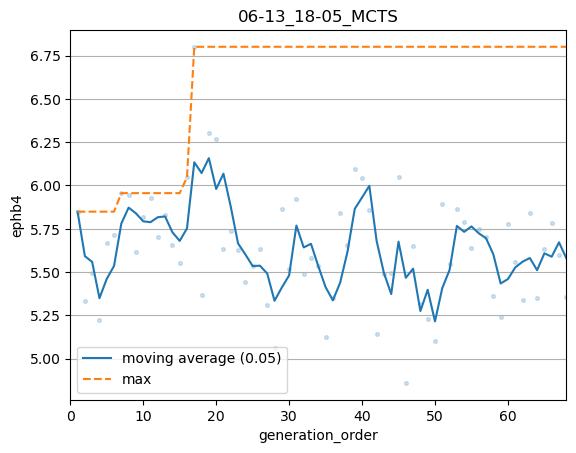

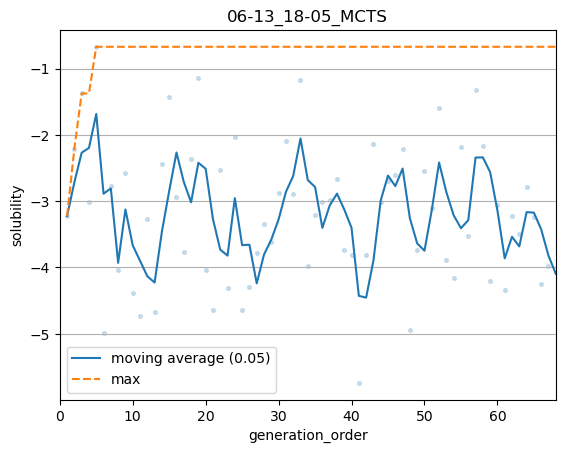

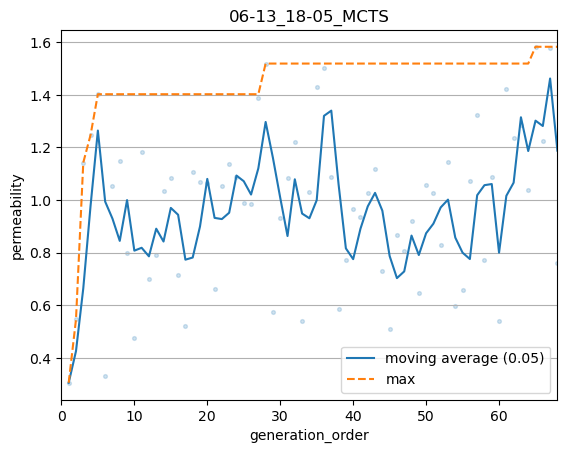

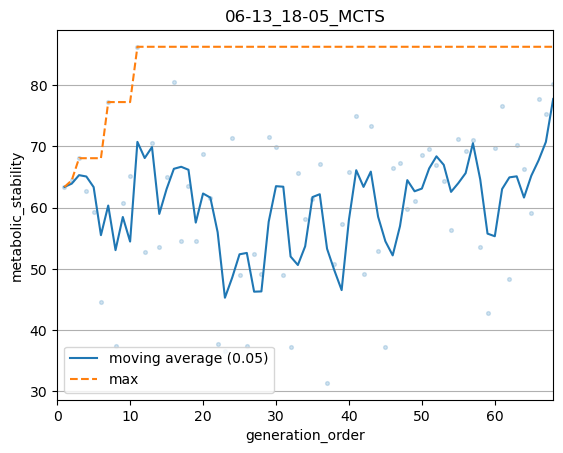

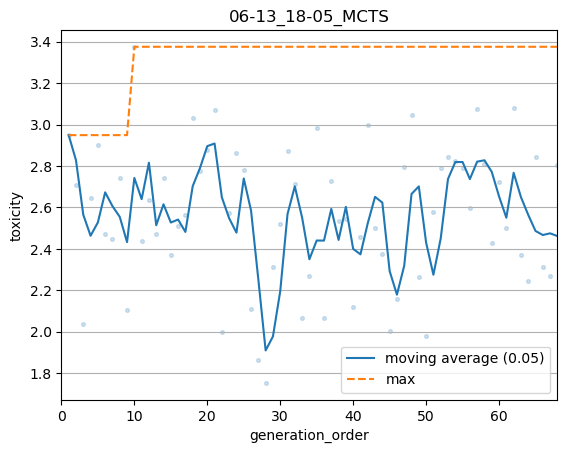

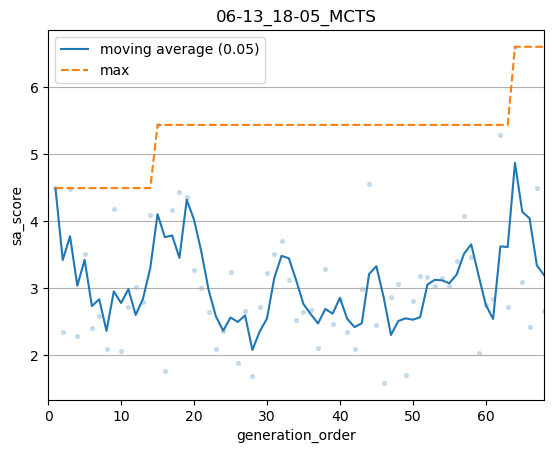

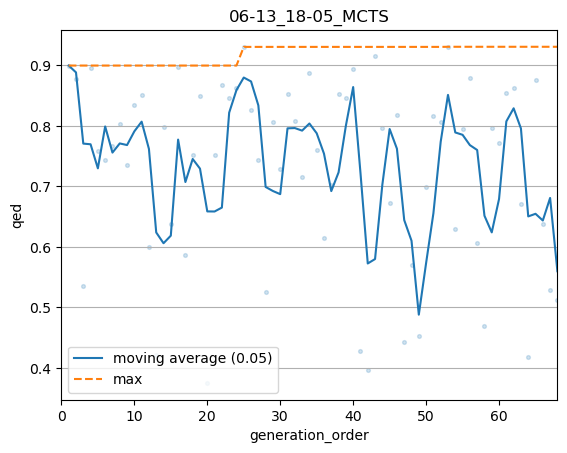

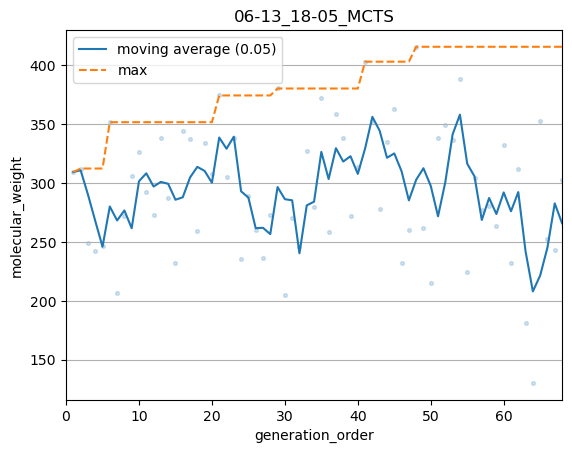

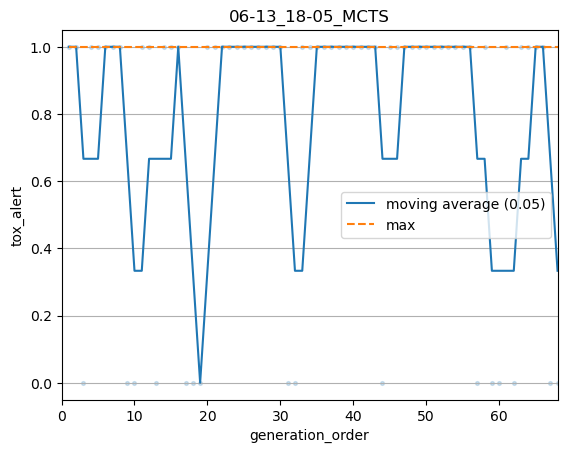

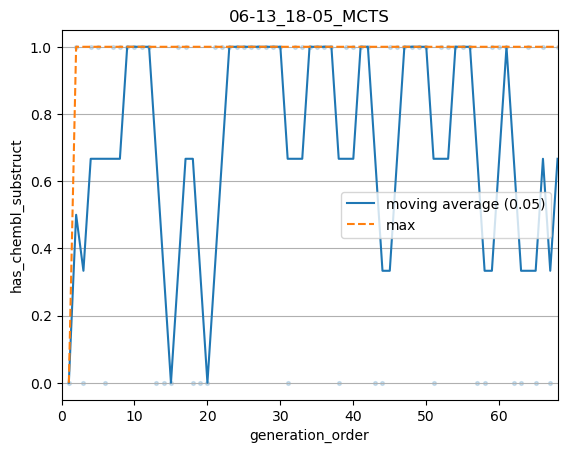

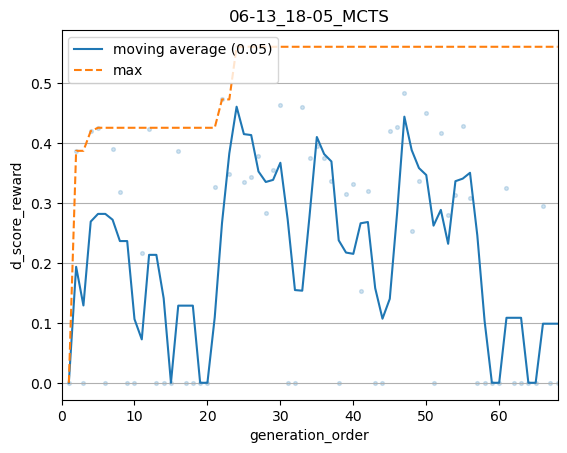

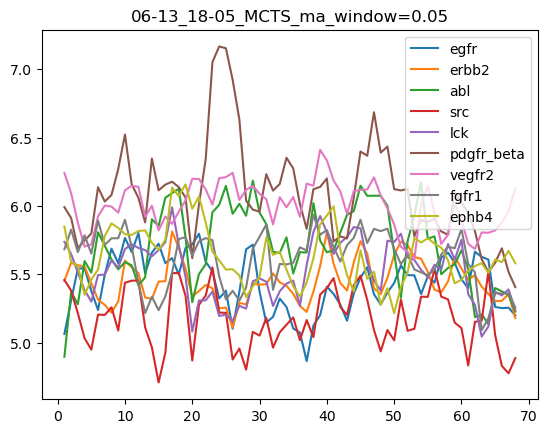

number of generated nodes: 68
valid rate: 0.5964912280701755
unique rate: 1.0
node_per_sec: 6.6729523147026635
Starting generation...
1- time: 0.00, reward: -0.9497492406645223, node: PEPTIDE1{[dF].A.D.A.I.F.T.N.S.Y.R.K.V.L.G.Q.L.S.A.R.K.L.L.Q.D.I.M.S.R.[am]}$$$$
2- time: 0.00, reward: -0.7339484368295806, node: PEPTIDE1{S.A.I.L.P.C.M.V.A.K.[am]}$$$$
3- time: 0.00, reward: -0.9302679507324295, node: PEPTIDE1{I.T.P.A.K.A.E.A.E.A.K.V.H.A.E.L.N.G.Q.A.K.A.S.[am]}$$$$


a


4- time: 0.13, reward: 0.9026307446736758, node: PEPTIDE1{A.A.E.A.A.L.E.A.E.L.A.A.L.E.G.K.S.[am]}$$$$
5- time: 0.13, reward: -0.9292006241529202, node: PEPTIDE1{Y.V.P.T.S.R.Q.A.N.F.R.K.V.Q.[am]}$$$$
6- time: 0.22, reward: -0.9301013973873944, node: PEPTIDE1{[ac].F.Q.S.K.G.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
7- time: 0.22, reward: -0.8654888751970857, node: PEPTIDE1{[ac].Q.V.Q.L.[dF].I.K.D.K.L.[am]}$$$$
8- time: 0.32, reward: -0.9349161902721872, node: PEPTIDE1{A.E.L.A.A.E.L.E.F.E.I.E.W.E.G.W.E.A.Q.E.W.E.Y.L.K.K.L.E.E.G.K.A.K.W.N.W.A}$$$$
9- time: 0.32, reward: -0.5685857126560546, node: PEPTIDE1{A.L.F.P}$$$$
10- time: 0.43, reward: -0.8571408326044214, node: PEPTIDE1{R.W.G.R.W.R.W.R.W}$$$$
11- time: 0.43, reward: -0.8840130335515616, node: PEPTIDE1{R.P.[dK].P.Q.Q.[dF].[dF].G.L.M.[am]}$$$$
12- time: 0.50, reward: -0.8997050043513282, node: PEPTIDE1{G.C.C.S.H.P.P.C.F.[Nva].P.[dE].C}$$$$
13- time: 0.50, reward: -0.9314780418402401, node: PEPTIDE1{G.L.Q.G.R.L.Q.R.L.L.Q.A.S.G.N.H.A.A.G.

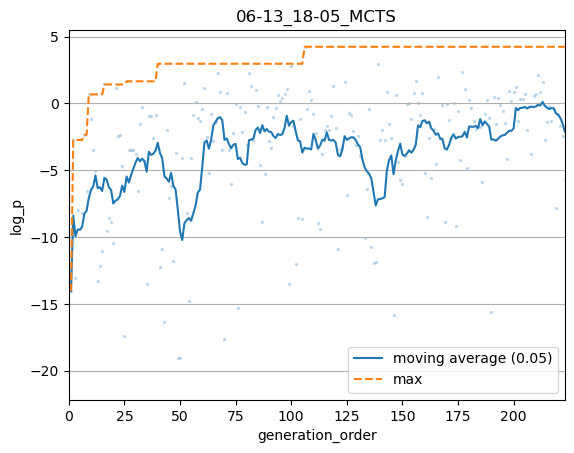

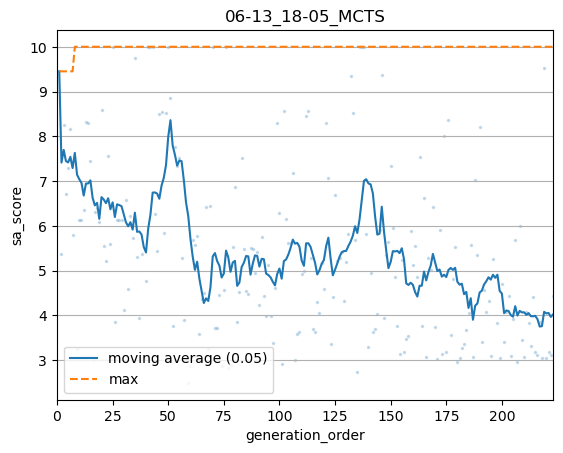

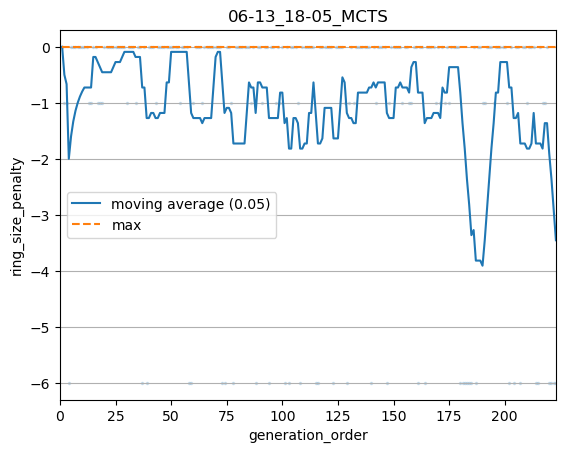

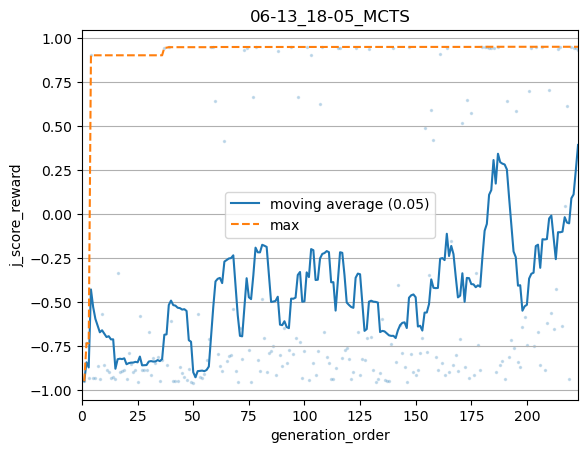

number of generated nodes: 223
valid rate: 0.5841346153846154
unique rate: 0.9519230769230769
node_per_sec: 22.266144535503216


In [ ]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
# execute_yaml(c1)
queue_yaml(c1, c2)

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts
load_path = os.path.join(output_dir, "06-09_22-15_MCTS_PUCT/test.mcts")
generator = MCTS.load(load_path, transition) #TODO: separate notebook